# Dependencias

In [1]:
import numpy as np 
import pandas as pd
import nltk
import matplotlib.pyplot as plt

# Load Data

In [2]:
data = pd.read_csv('./mails_clean.csv')
print(data.shape)

(42638, 10)


In [3]:
# tmp
data = data.head(1000)

In [4]:
data=data.drop(columns=['Unnamed: 0','X-cc','X-bcc'])
data=data.dropna(axis=0,subset=['body'],how='any')
print(data.shape)
data.head()

(978, 7)


,file,Message-ID,Date,From,To,Subject,body
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00,{'phillip.allen@enron.com'},{'tim.belden@enron.com'},NaN,Here is our forecast
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00,{'phillip.allen@enron.com'},{'john.lavorato@enron.com'},Re:,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00,{'phillip.allen@enron.com'},{'leah.arsdall@enron.com'},Re: test,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00,{'phillip.allen@enron.com'},{'randall.gay@enron.com'},NaN,"Randy, Can you send me a schedule of the sal..."
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00,{'phillip.allen@enron.com'},{'greg.piper@enron.com'},Re: Hello,Let's shoot for Tuesday at 11:45.


# Pre-Procesamiento

In [5]:
import re
def clean_from_mails(message):
  mail_addresses = re.findall(r'\(?[A-Za-z0-9_\-\.]+@[A-Za-zb0-9_\-\.]+\.com\)?',message)
  if mail_addresses != []:
    for mail_address in mail_addresses:
      message=message.replace(mail_address,'').strip()
  return message

In [6]:
# Eliminar emails del body
data['body_clean']=data['body'].map(clean_from_mails)

In [7]:
# Eliminar palabras con digitos y signos de puntuacion
data['body_clean']=data['body_clean'].map(lambda x: ' '.join(re.sub(r'[^a-zA-Z]',' ',x).split()))

In [8]:
# Pasar todo a minusculas
data['body_clean']=data['body_clean'].map(lambda x: x.lower())

## Stopwords

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/kref/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
my_stopwords = stopwords.words('english')
# Excluir palabras de una sola letra
for i in range(ord('a'),ord('z')+1):
  my_stopwords.append(chr(i))
# Añadir would
my_stopwords = my_stopwords + ['also','please','would']
print(f'Stopwords final ({len(my_stopwords)}):')
print(my_stopwords)

Stopwords final (208):
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 

In [11]:
def clean_msg_stopwords(message_body):
    words = message_body.split()
    words = [w for w in words if w not in set(my_stopwords)]
    return ' '.join(words)

In [12]:
# Eliminar stopwords
data['body_clean']=data.body_clean.apply(clean_msg_stopwords)

In [13]:
data=data.dropna(axis=0,subset=['body_clean'],how='any')
print(data.shape)

(978, 8)


## Tokenizacion

In [14]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kref/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
word_vector = []
for doc in data['body_clean']:
  word_vector.append(doc.split())
my_vocabulary = [item for sublist in word_vector for item in sublist]

In [16]:
word_vector[4]

['let', 'shoot', 'tuesday']

In [17]:
print(f'El vocabulario consta de {len(my_vocabulary)} elementos y {len(set(my_vocabulary))} palabras diferentes.')

El vocabulario consta de 48059 elementos y 4878 palabras diferentes.


## Lematizacion

In [77]:
from collections import Counter

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/kref/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

def lemmatize_body(message_body):
  return ' '.join(lemma.lemmatize(word) for word in message_body.split())

In [20]:
lemma_vector = []
for doc in data['body_clean']:
  lemma_vector.append(lemmatize_body(doc).split())
my_lema_voc = [item for sublist in lemma_vector for item in sublist]

In [21]:
print(f'El vocabulario de lemas consta de {len(my_lema_voc)} elementos y {len(set(my_lema_voc))} palabras diferentes.')

El vocabulario de lemas consta de 48059 elementos y 4408 palabras diferentes.


In [22]:
data['body_lemma'] = data['body_clean'].map(lemmatize_body)

In [23]:
data['body_lemma'][4]

'let shoot tuesday'

# Vectorizacion

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
word_vector = []
for doc in data['body_lemma']:
  word_vector.append(doc.split())
my_vocabulary = [item for sublist in word_vector for item in sublist]

In [26]:
word_vector[4]

['let', 'shoot', 'tuesday']

In [27]:
data['body_lemma'][4]

'let shoot tuesday'

# Similaridad de Documentos

In [28]:
import gensim

In [29]:
dictionary = gensim.corpora.Dictionary(word_vector)

In [30]:
dictionary[78]

'tuesday'

In [33]:
print(dictionary.token2id["tuesday"])

78


In [34]:
print("Number of words in dictionary:",len(dictionary))

Number of words in dictionary: 4408


In [35]:
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in word_vector]

In [36]:
corpus[4]

[(76, 1), (77, 1), (78, 1)]

In [37]:
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)

TfidfModel(num_docs=978, num_nnz=35752)


In [38]:
tf_idf[corpus[4]]

[(76, 0.263211681806293), (77, 0.8535374553666696), (78, 0.4496592296916557)]

## Analisis de Clusters

In [43]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [78]:
lema_counts = Counter(my_vocabulary)

In [81]:
df_lema = pd.DataFrame.from_dict(lema_counts, orient='index')

In [91]:
df_lema=df_lema.reset_index()
df_lema.columns=['word','freq']

In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline

n=2
tf_idf_dense = tf_idf_m.todense()
coords = PCA(n_components=n).fit_transform(tf_idf_dense)

plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [94]:
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
analysis_df = data['body_lemma'].sample(n=600)
vectorizer = TfidfVectorizer(vocabulary=df_lema['word'],max_df=0.5,min_df=2)
tf_idf_m = vectorizer.fit_transform(analysis_df.tolist())
labels = clf.fit_predict(tf_idf_m)

In [95]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0","#ee82ee","#fffff0","#800000","#800080"]
color = [label[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = PCA(n_components=n).fit(tf_idf_dense).transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()

NameError: name 'coords' is not defined

In [61]:
d2v_data = ["I love machine learning. Its awesome.",
        "I love coding in python",
        "I love building chatbots",
        "they chat amagingly well"]

In [66]:
all_content

[TaggedDocument(words=['I', 'love', 'machine', 'learning', '.', 'Its', 'awesome', '.'], tags=['0']),
 TaggedDocument(words=['I', 'love', 'coding', 'in', 'python'], tags=['1']),
 TaggedDocument(words=['I', 'love', 'building', 'chatbots'], tags=['2']),
 TaggedDocument(words=['they', 'chat', 'amagingly', 'well'], tags=['3'])]

In [68]:
all_content = [TaggedDocument(words=word_tokenize(_d), tags=[str(i)]) for i, _d in enumerate(data['body_lemma'].values)]

In [63]:
all_content = [TaggedDocument(words=word_tokenize(_d), tags=[str(i)]) for i, _d in enumerate(d2v_data)]

In [69]:
d2v_model = Doc2Vec(all_content, vector_size = 2000, window = 10, min_count = 500, workers=7, dm = 1, 
                alpha=0.025, min_alpha=0.001)

In [70]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)

In [71]:
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
labels=kmeans_model.labels_.tolist()

In [72]:
l = kmeans_model.fit_predict(d2v_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

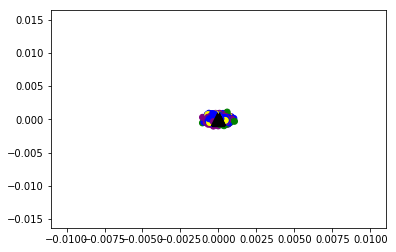

In [73]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [ ]:
tf_idf[corpus]

In [ ]:

n_clusters = 6
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(tf_idf[corpus])

In [ ]:
type(word_vector)

In [ ]:
d2v_model = Doc2Vec(word_vector, vector_size = 2000, window = 10, min_count = 500, workers=7, dm = 1, 
                alpha=0.025, min_alpha=0.001)

In [ ]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)  

In [ ]:
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)

## Procesamiento Similaridad

In [ ]:
sims = gensim.similarities.Similarity('./',tf_idf[corpus],
                                      num_features=len(dictionary))
print(sims)
print(type(sims))

## Query

In [98]:
def make_query_tf_idf(query):
    query_doc = [w.lower() for w in word_tokenize(query)]
    query_doc_bow = dictionary.doc2bow(query_doc)
    return tf_idf[query_doc_bow]

In [ ]:
def get_n_most_similar(mail_id, n):
  query = data['body_lemma'][mail_id]
  print('------------------------ [ Query ] ------------------------')
  print(data['body'][mail_id])
  ranking = sims[make_query_tf_idf(query)]
  sim_w_index = list(enumerate(ranking))
  x = [t[0] for t in list(reversed(sorted(sim_w_index,key=lambda x: x[1])))]
  print()
  print('---------- [ Most similar emails (index, score)] ----------')
  print(list(reversed(sorted(sim_w_index,key=lambda x: x[1])))[:n])
  print()
  print('------------------------ [ emails] ------------------------')
  for ind in x[:n]:
    print('From: {}'.format(data['From'][ind]))
    print('To: {}'.format(data['To'][ind]))
    print(data['body'][ind])
    print('---------------------------------------------------------')

In [ ]:
data['body_lemma'][45]

In [ ]:
get_n_most_similar(45,5)

In [100]:
data['body_lemma'][4]

'let shoot tuesday'

In [99]:
make_query_tf_idf(data['body_lemma'][4])

[(76, 0.263211681806293), (77, 0.8535374553666696), (78, 0.4496592296916557)]